In [1]:
#Dependencies (in order of usage)
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import datetime as dt
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt

In [2]:
#Load engine created in database_engineering
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
#Make sure it is loaded

In [4]:
engine.execute('SELECT * FROM prcp LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08),
 (2, 'USC00519397', '2010-01-02', 0),
 (3, 'USC00519397', '2010-01-03', 0),
 (4, 'USC00519397', '2010-01-04', 0),
 (5, 'USC00519397', '2010-01-07', 0.06)]

In [5]:
#I'm satisfied checking just one table - good enough

In [6]:
# Upload the Base 
Base = automap_base()

In [7]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [8]:
# Mapped classes are now created with names by default
# matching that of the table name.
Base.classes.keys()

['prcp', 'stations', 'tobs']

In [9]:
# Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called 
# Station and [prcp, tobs].

In [10]:
# Reflect Database into ORM class ===save references
prcp = Base.classes.prcp
tobs = Base.classes.tobs
stations = Base.classes.stations

In [11]:
# Start a session to query the database
session = Session(engine)

In [12]:
#Precipitation Analysis

In [13]:
#Design a query to retrieve the last 12 months of precipitation data.
date = session.query(prcp.date).order_by(prcp.date.desc()).first()
print(date)

('2017-08-23',)


In [14]:
first_date = '2016-08-23'

In [15]:
# Select only the date and prcp values.
prcp = session.query(prcp.date, prcp.prcp).\
    filter(prcp.date > first_date).\
    order_by(prcp.date).all()

In [16]:
#Load the query results into a Pandas DataFrame and set the index to the date column.
prcp_df = pd.DataFrame(prcp)
prcp_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,1.22
4,2016-08-24,2.15


In [17]:
#Convert the date column into a datetime
prcp_df['date'] = [dt.datetime.strptime(x, "%Y-%m-%d") for x in prcp_df['date']]

In [18]:
#Check conversion
type(prcp_df['date'][0])

pandas._libs.tslib.Timestamp

In [19]:
prcp_df=prcp_df.set_index('date')
prcp_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


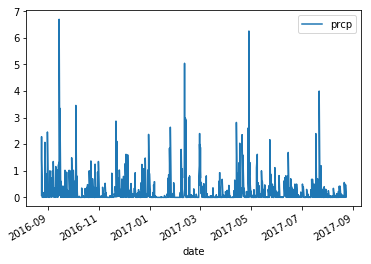

In [20]:
prcp_df.plot()

In [21]:
#Use Pandas to print the summary statistics for the precipitation data.
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
#Station Analysis

In [23]:
#Design a query to calculate the total number of stations.
session.query(stations).count()

9

In [24]:
#Design a query to find the most active stations.
#USC00519281 had the highest number of obs, at 2772
session.query(tobs.station, func.count(tobs.tobs)).group_by(tobs.station).\
               order_by(func.count(tobs.tobs).desc()).all() 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
#Design a query to retrieve the last 12 months of temperature observation data (tobs)
#Filter by the station with the highest number of observations. 
temps = session.query(tobs.date, tobs.tobs).\
    filter(tobs.station == 'USC00519281').\
    filter(tobs.date > first_date).\
    order_by(tobs.date.asc()).all()

In [26]:
#Load the query results into a Pandas DataFrame and set the index to the date column.
temp_df = pd.DataFrame(temps)

In [27]:
#Convert the date column into a datetime
temp_df['date'] = [dt.datetime.strptime(x, "%Y-%m-%d") for x in temp_df['date']]

In [28]:
#Check conversion
type(temp_df['date'][0])

pandas._libs.tslib.Timestamp

In [29]:
#Describe dates
temp_df['date'].describe()

count                     351
unique                    351
top       2016-09-08 00:00:00
freq                        1
first     2016-08-24 00:00:00
last      2017-08-18 00:00:00
Name: date, dtype: object

In [30]:
#Set index to date
temp_df=temp_df.set_index('date')
temp_df.head()

,tobs
date,
2016-08-24,77
2016-08-25,80
2016-08-26,80
2016-08-27,75
2016-08-28,73


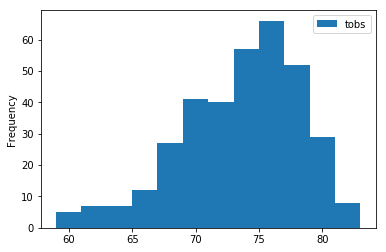

In [31]:
#Plot the results as a histogram with bins=12
temp_df.plot(kind="hist", bins=12)

In [32]:
#Temperature Analysis

In [33]:
#Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the 
#matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

In [34]:
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d 
# and return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(start_date, end_date):
    temp_vals= session.query(func.min(tobs.tobs), func.avg(tobs.tobs), func.max(tobs.tobs)).\
        filter(tobs.date >= start_date).filter(tobs.date <= end_date).all()
    min = temp_vals[0][0]
    avg = temp_vals[0][1]
    max = temp_vals[0][2]
    return {'min':min,'avg':avg,'max':max}

In [35]:
#My trip will start on July 3rd to July 10th, 2018. Therefore, I test for July 3-10 of 2017

In [36]:
#Test that the function works
temp_d = (calc_temps('2017-07-03', '2017-07-10'))
print(temp_d)

{'min': 69, 'avg': 78.12, 'max': 87}


In [37]:
means = pd.DataFrame({"avg":temp_d.get('avg')}, index=["My Trip"])
error = (temp_d.get('max')-temp_d.get('min'))

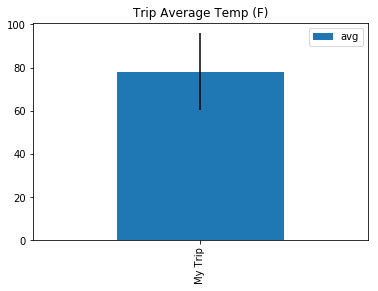

In [38]:
means.plot(kind="bar",yerr=error,title="Trip Average Temp (F)")